The segmentation_models package works better by tensorflow version 1.x

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!pip install -U segmentation-models==0.2.1
!pip install h5py==2.10.0

     |████████████████████████████████| 44 kB 2.2 MB/s 
     |████████████████████████████████| 76 kB 4.1 MB/s 
     |████████████████████████████████| 2.9 MB 7.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0


Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#change directory to data folder
cd 'Ehsan' 

In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:
import keras
from keras import backend as K
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from glob import glob
from segmentation_models import Unet,PSPNet,FPN,Linknet
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Conv2D
from keras.models import Model
import pdb
import pickle
import os
import cv2
import pandas as pd

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


Define Generator

In [ ]:
palette = {(0,  0, 0) : 0,
           (255,  0, 0) : 1,
           (0,   255,   0) : 2 ,
           (0,   0,   255) : 3 ,
           (0,   255,   255) : 4,
           (255,   0,   255) : 5
         }
# Set image size
img_size=384
# Set batch size
Batch_size=25

In [ ]:
def batch_generator(folder,sample_number,batch_size=20):
    list_files=glob(folder+'_images_400/*.tif')
    permutated_indices = np.random.permutation(len(list_files))
    while True:
      for index in range(int(sample_number / batch_size)):
        batchX=np.zeros(shape=(batch_size,img_size,img_size,4),dtype=np.int16)
        batchY=np.zeros(shape=(batch_size,img_size,img_size,6),dtype=np.int8)
        batch_indices = permutated_indices[index*batch_size:(index+1)*batch_size]
        counter=0
        for idx in batch_indices:
          img=io.imread(list_files[idx], plugin='pil')
          #
          img11=img[np.int(np.ceil(img.shape[0]/2)-img_size/2):np.int(np.ceil(img.shape[0]/2)+img_size/2),np.int(np.ceil(img.shape[1]/2)-img_size/2):np.int(np.ceil(img.shape[1]/2)+img_size/2),:]
          #
          batchX[counter]=np.int16(img11)
          #
          img_out_name=str.replace(list_files[idx],'_images','_labels')
          img_out_name=str.replace(img_out_name,'_2011.tif','.png')
          img_out_name=str.replace(img_out_name,'.tif','.png')
          img_llabel=io.imread(img_out_name)
          img_label=img_llabel[np.int(np.ceil(img_llabel.shape[0]/2)-img_size/2):np.int(np.ceil(img_llabel.shape[0]/2)+img_size/2),np.int(np.ceil(img_llabel.shape[1]/2)-img_size/2):np.int(np.ceil(img_llabel.shape[1]/2)+img_size/2):]
          # 
          labels=np.zeros(shape=(img_size,img_size,6),dtype=np.int8)
          for ccd, iiig in palette.items():
            yutr=np.zeros(shape=(img_size,img_size),dtype=np.int8)
            mds = np.all(img_label == np.array(ccd).reshape(1, 1, 3), axis=2)
            yutr[mds]=1
            labels[:,:,iiig]=yutr
          batchY[counter]=labels
            #
          counter += 1
        yield [batchX[:,:,:,0:3], batchY]

In [ ]:
len(glob('test_images/*.tif'))

1384

# Define the model, run and save

In [ ]:
model = Unet(backbone_name='resnet34', encoder_weights='imagenet',classes=6,input_shape=(None, None, 3), activation='softmax')
model.compile(optimizer=keras.optimizers.adadelta(lr=1), loss='categorical_crossentropy', metrics=['binary_crossentropy','accuracy'])
# Save model's structure
json_string = model.to_json()
with open('model_name.json','wb') as handle: 
    pickle.dump(json_string,handle)#

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [ ]:
callbacks = [
    EarlyStopping(patience=20, verbose=1),
  ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0000001, verbose=1),
    ModelCheckpoint('model_name.h5', verbose=1, save_best_only=True)]

In [ ]:
results = model.fit_generator(batch_generator('train',batch_size=Batch_size, sample_number=5720),steps_per_epoch=np.int(5720/Batch_size),epochs=37, callbacks=callbacks,
                              validation_data=batch_generator('val',batch_size=Batch_size, sample_number=1500), validation_steps=np.int(1500/Batch_size),shuffle=True, initial_epoch=0,class_weight={1,0.1,1,1,1,1})

# Load a saved model

In [ ]:
from keras.models import load_model,model_from_json
with open('model_384_json_3d_trainable_categorical.json', 'rb') as handle:
  model_json = pickle.load(handle)
model = model_from_json(model_json)
model.load_weights("model_384_0.1other1_epoch-13_val_loss-0.5015.h5")
# model1.compile('adam', loss='categorical_crossentropy', metrics=['binary_crossentropy','accuracy',dice_loss,iou_score,bce_jaccard_loss])
model.compile(optimizer=keras.optimizers.Adadelta(lr=1), loss='categorical_crossentropy', metrics=['binary_crossentropy','accuracy'])


In [ ]:
def showfig(file_name): 
  if 1==1:
    img=io.imread(file_name, plugin='pil')
    img11=img[np.int(np.ceil(img.shape[0]/2)-img_size/2):np.int(np.ceil(img.shape[0]/2)+img_size/2),np.int(np.ceil(img.shape[1]/2)-img_size/2):np.int(np.ceil(img.shape[1]/2)+img_size/2),:3]
  #
    img_out_name=str.replace(file_name,'_images','_labels')
    img_out_name=str.replace(img_out_name,'.tif','.png')
    img_llabel=io.imread(img_out_name)
    img_label=img_llabel[np.int(np.ceil(img_llabel.shape[0]/2)-img_size/2):np.int(np.ceil(img_llabel.shape[0]/2)+img_size/2),np.int(np.ceil(img_llabel.shape[1]/2)-img_size/2):np.int(np.ceil(img_llabel.shape[1]/2)+img_size/2):]
    # 
    labels=np.zeros(shape=(img_size,img_size,6),dtype=np.int8)
    for ccd, iiig in palette.items():
      yutr=np.zeros(shape=(img_size,img_size),dtype=np.int8)
      mds = np.all(img_label == np.array(ccd).reshape(1, 1, 3), axis=2)
      yutr[mds]=1
      labels[:,:,iiig]=yutr
  #   batchY[counter]=labels
  # **********************
    predict_label=np.zeros((384,384,3),dtype=np.int16)
    out=model.predict(np.expand_dims(np.int16(img11),axis=0))
    for i in range(0,384):
      for j in range(0,384):
        max_val=np.argmax(out[0,i,j,:])
        for ccd, iiig in palette.items():
          if iiig==max_val:
            predict_label[i,j]=ccd
    plt.subplot(121)
    plt.imshow(predict_label)
    plt.title('predict')
    # plt.subplot(132)
    # plt.imshow(predict_label1)
    plt.subplot(122)
    plt.imshow(img_label)
    plt.title('observe')
    plt.show()
    print(model.evaluate(np.expand_dims(np.int16(img11),axis=0),np.expand_dims(labels,axis=0)))

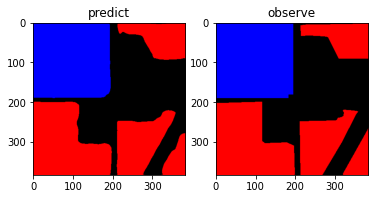

1/1 [==============================] - 1s 775ms/step
[0.07854124903678894, 0.0258334968239069, 0.9735514521598816]


In [ ]:
showfig('train_images/train_image_104.tif')